# DBBA Coursework 1

#### Name: Teofebano Kristo       
#### Student Number: S2594631

--------------------------------------------------------------------------------------------------------------------------------------------

### Instructions

#### Academic Misconduct

Please remember the good scholarly practice requirements of the University regarding work for
credit. You can find guidance at the School page

https://web.inf.ed.ac.uk/infweb/admin/policies/academic-misconduct

This also has links to the relevant University pages. 

**You are not allowed to collaborate with other students on this assignment or to ask or answer questions about the contents of the assignment. If you do not understand a specific question, ask Valerio and Ogy on Piazza.**

#### Submission Instructions

All the analysis must be done in this Jupyter Notebook and you should have a separate written report (without code) saved in PDF. Please fill out the fields bellow with the necessary code(remember to comment your code well) and discussion where needed. Code will generally
not be marked, but it will be checked by the markers to ensure that all the analysis is properly
done and the work is yours (i.e. there was no plagiarism). Focus on analysing the results you obtain as this is the main part that will be marked. Report your findings in a PDF file where you do not include any code but just the figures obtained and the conclusions you draw, i.e. plots and analysis. You will have to submit your files (final Jupyter Notebook and PDF) on Learn. Name your files with your
student number. For instance, if your student number is S123456789, you must submit a file
S123456789.zip containing the python source code and answers to the questions (PDF).

#### General Instructions 
In this coursework, you will analyse a real-world temporal network based on what you have learned in
class. Many exercises will require you to discuss the results of your analysis, some other will leave
you the choice of which algorithm to use for a particular task. This is by design because this
coursework assesses whether you understand network science and whether you can apply it to
real-world networks. For this reason, if you realise you need to make assumptions to answer a
question, do so and always, always motivate your assumptions and answers!

**Warning:** Some network metrics might require some time to compute. Please consider this when
doing the coursework and allow enough time to perform the required computations. Also
remember that you can use the School’s DICE machines, which can be let to run!

--------------------------------------------------------------------------------------------------------------------------------------------

#### Assignment Premises

You have been hired as a data analyst in the newly founded investment company DBBA Capital and have been tasked with the analysis of the investment patterns of one of our major competitors: Fairholme Capital, managed by Bruce Berkowitz. 

DBBA Capital wants you to evaluate the investment patterns of Fairholme Capital in relation to other superinvestors and evaluate the change in investment patterns during the pandemic. They have provided you with data about different superinvestors and the companies they invested in for each quarter spanning from quarter 1 (Q1) of 2019 to quarter 2 (Q2) of 2023 (that you can find in the folder named "Assignment Data"). 

The first column of each file represents the investors and the remaining columns represent the companies each investor invested in. First, familiarlise yourself with the data, and then, follow the steps bellow to perform the necessary analysis.

**TIP** When you believe it might help, make use of the information you have on the portfolio composition to comment and discuss your results.

# Library Management

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
%matplotlib inline

import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

from tabulate import tabulate

# Methods

In [124]:
# Drawing Network
def draw_graphviz(G, id, nodecolor, spreadprogram='neato'):
    # init plt     
    plt.figure(id, figsize=(15,15))
    
    # use pydot and graphviz for better layout    
    pos = graphviz_layout(G, prog = spreadprogram)
    color_map = []
    for node in G:
        if node == 'Bruce Berkowitz - Fairholme Capital':
            # highlighting Fairholme Capital with different color             
            color_map.append('orange')
        else: 
            color_map.append(nodecolor)

    nx.draw(G, pos, node_color = color_map, with_labels = True, node_size=1000, font_size=8)
    
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    
    # draw
    plt.show()

In [125]:
# Populate Network
def populate_graph(G, dataframe):
    for index, row in dataframe.iterrows():
        investors = dataframe.iloc[:, 0]
        G.add_nodes_from(investors);
        
    for i in range(len(investors)):
        investori = dataframe.iloc[i,0]
        stocksi = dataframe.iloc[i,1:]
        clean_stocksi = stocksi.dropna()
        
        for j in range(i + 1, len(investors)):
            investorj = dataframe.iloc[j,0]
            stocksj = dataframe.iloc[j,1:]
            clean_stocksj = stocksj.dropna()
            
            common_values = list(set(clean_stocksi) & set(clean_stocksj))
            
            if len(common_values) > 0:
                G.add_edge(investori, investorj)
                G[investori][investorj]['weight'] = len(common_values)
                
def add_strength_to_nodes(G):
    strengths = {}
    for node in G.nodes():
        strength = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
        strengths[node] = strength
    
    nx.set_node_attributes(G, strengths, "strength")
    
def add_clustering_to_nodes(G):
    clusterings = {}
    for node in G.nodes():
        clustering = nx.clustering(G, node)
        clusterings[node] = clustering
    
    nx.set_node_attributes(G, clusterings, "clustering")

In [126]:
# Extract Giant Component
def extra_giant_component_from_graph(G):
    G_CC = sorted(nx.connected_components(G), key=len, reverse=True)
    Giant_G = G.subgraph(G_CC[0])
    
    return Giant_G

In [127]:
# Build Ego Network
def build_ego_network_for_node(G, node):
    return nx.ego_graph(G, node)

In [170]:
# Print Network Summary
def get_network_summary_for_graph(G):
    nodesCount = G.number_of_nodes()
    
    edgesCount = G.number_of_edges()

    density = nx.density(G)
    
    averageClustering = nx.average_clustering(G)

    degrees = [val for (node, val) in G.degree()]
    sumDegrees = sum(degrees)
    averageDegrees = sumDegrees / nodesCount

    # index 0 is node name, index 1 is weights for that particular node
    weights = G.degree(weight='weight')
    averageStrength = sum(weight[1] for weight in weights) / nodesCount 

    degreeAssortativity = nx.degree_assortativity_coefficient(G)
    
    strengthAssortativity = nx.numeric_assortativity_coefficient(G, "strength")
    
    clusteringAssortativity = nx.numeric_assortativity_coefficient(G, "clustering")

#     data = [[nodesCount, 
#              edgesCount, 
#              density, 
#              averageClustering, 
#              averageDegrees, 
#              averageStrength, 
#              degreeAssortativity, 
#              strengthAssortativity, 
#              clusteringAssortativity
#             ]]
#     print (tabulate(data, headers=["#nodes", 
#                                    "#edges", 
#                                    "d", 
#                                    "<C>", 
#                                    "<k>", 
#                                    "<s>", 
#                                    "k-Assort", 
#                                    "s-Assort", 
#                                    "C-Assort"
#                                   ]))
    
    return {
        "nodesCount": nodesCount, 
        "edgesCount": edgesCount, 
        "density": density, 
        "averageClustering": averageClustering, 
        "averageDegrees": averageDegrees, 
        "averageStrength": averageStrength, 
        "degreeAssortativity": degreeAssortativity, 
        "strengthAssortativity": strengthAssortativity, 
        "clusteringAssortativity": clusteringAssortativity
    }


#### Part 1: Network Creation

**Task 1.1 (7 marks)**<br>
In the field below, load the first Excel dataset ("2019_Q1.xlsx") and create a network out of the investors and companies in the following manner:

- the nodes of the network are all the investors in the first column of the dataset
- two investors (nodes) are connected with an edge if the have invested in the same company (e.g. Christopher Bloomstran - Semper Augustus and David Abrams - Abrams Capital Management will be connected because they both invested in GOOGL). 
- if two investors have invested in more than one common comapny, do *not* assign multiple edges between them. Instead, assign the number of common companies they have invested in as a weight to the edge connecting them.

After you built the network, extract the largest connected component and plot it. Remember to add the edge weights in your plot.

In [129]:
#CODE HERE
df_2019_Q1 = pd.read_excel('./Assignment_Data/2019_Q1.xlsx', header=None)

G_2019_Q1 = nx.Graph()
populate_graph(G_2019_Q1, df_2019_Q1)

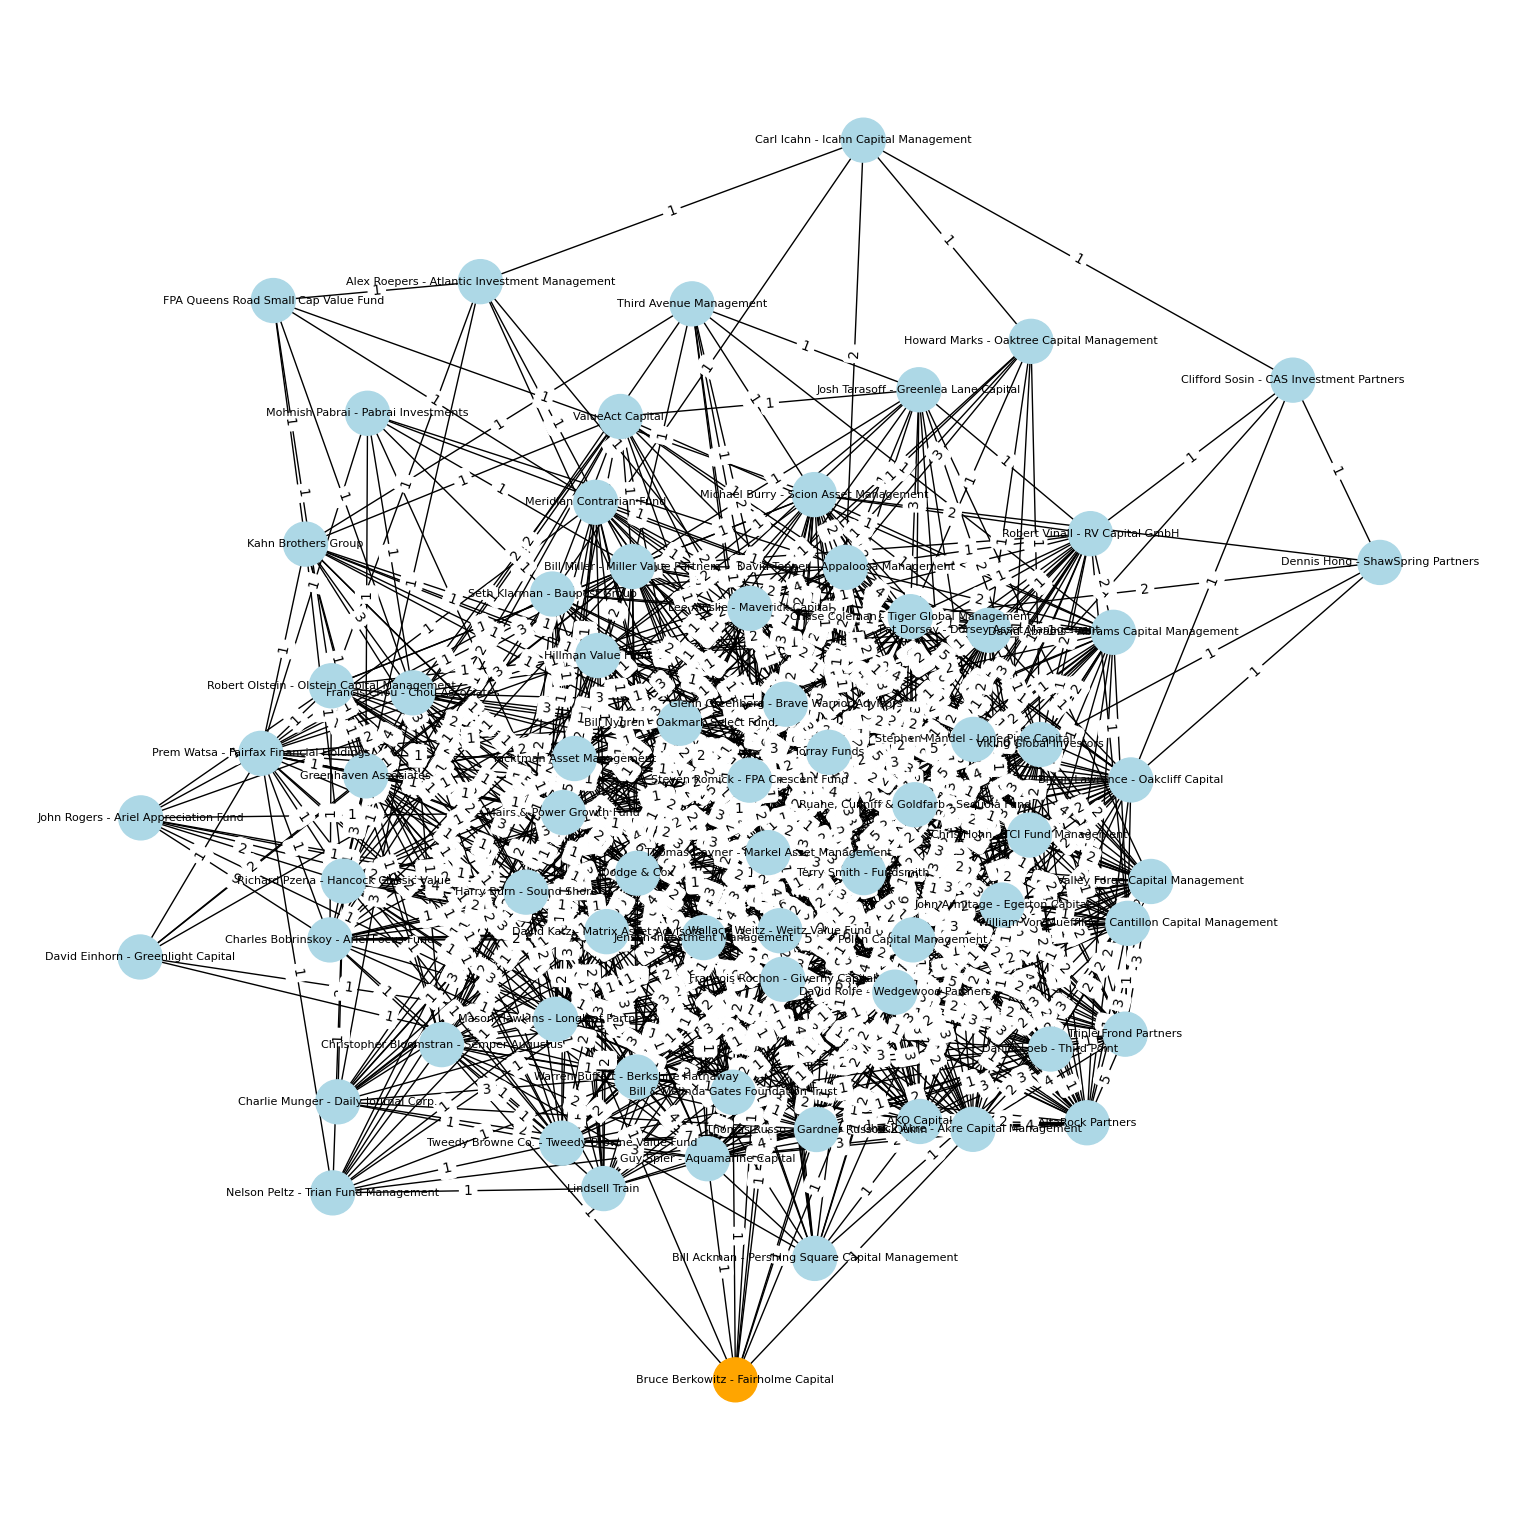

In [130]:
Giant_G_2019_Q1 = extra_giant_component_from_graph(G_2019_Q1)

draw_graphviz(Giant_G_2019_Q1, 'Giant_G_2019_Q1', 'lightblue')

**Task 1.2 (3 marks)** <br>
Obtain the ego-network of 'Bruce Berkowitz - Fairholme Capital' and plot it.

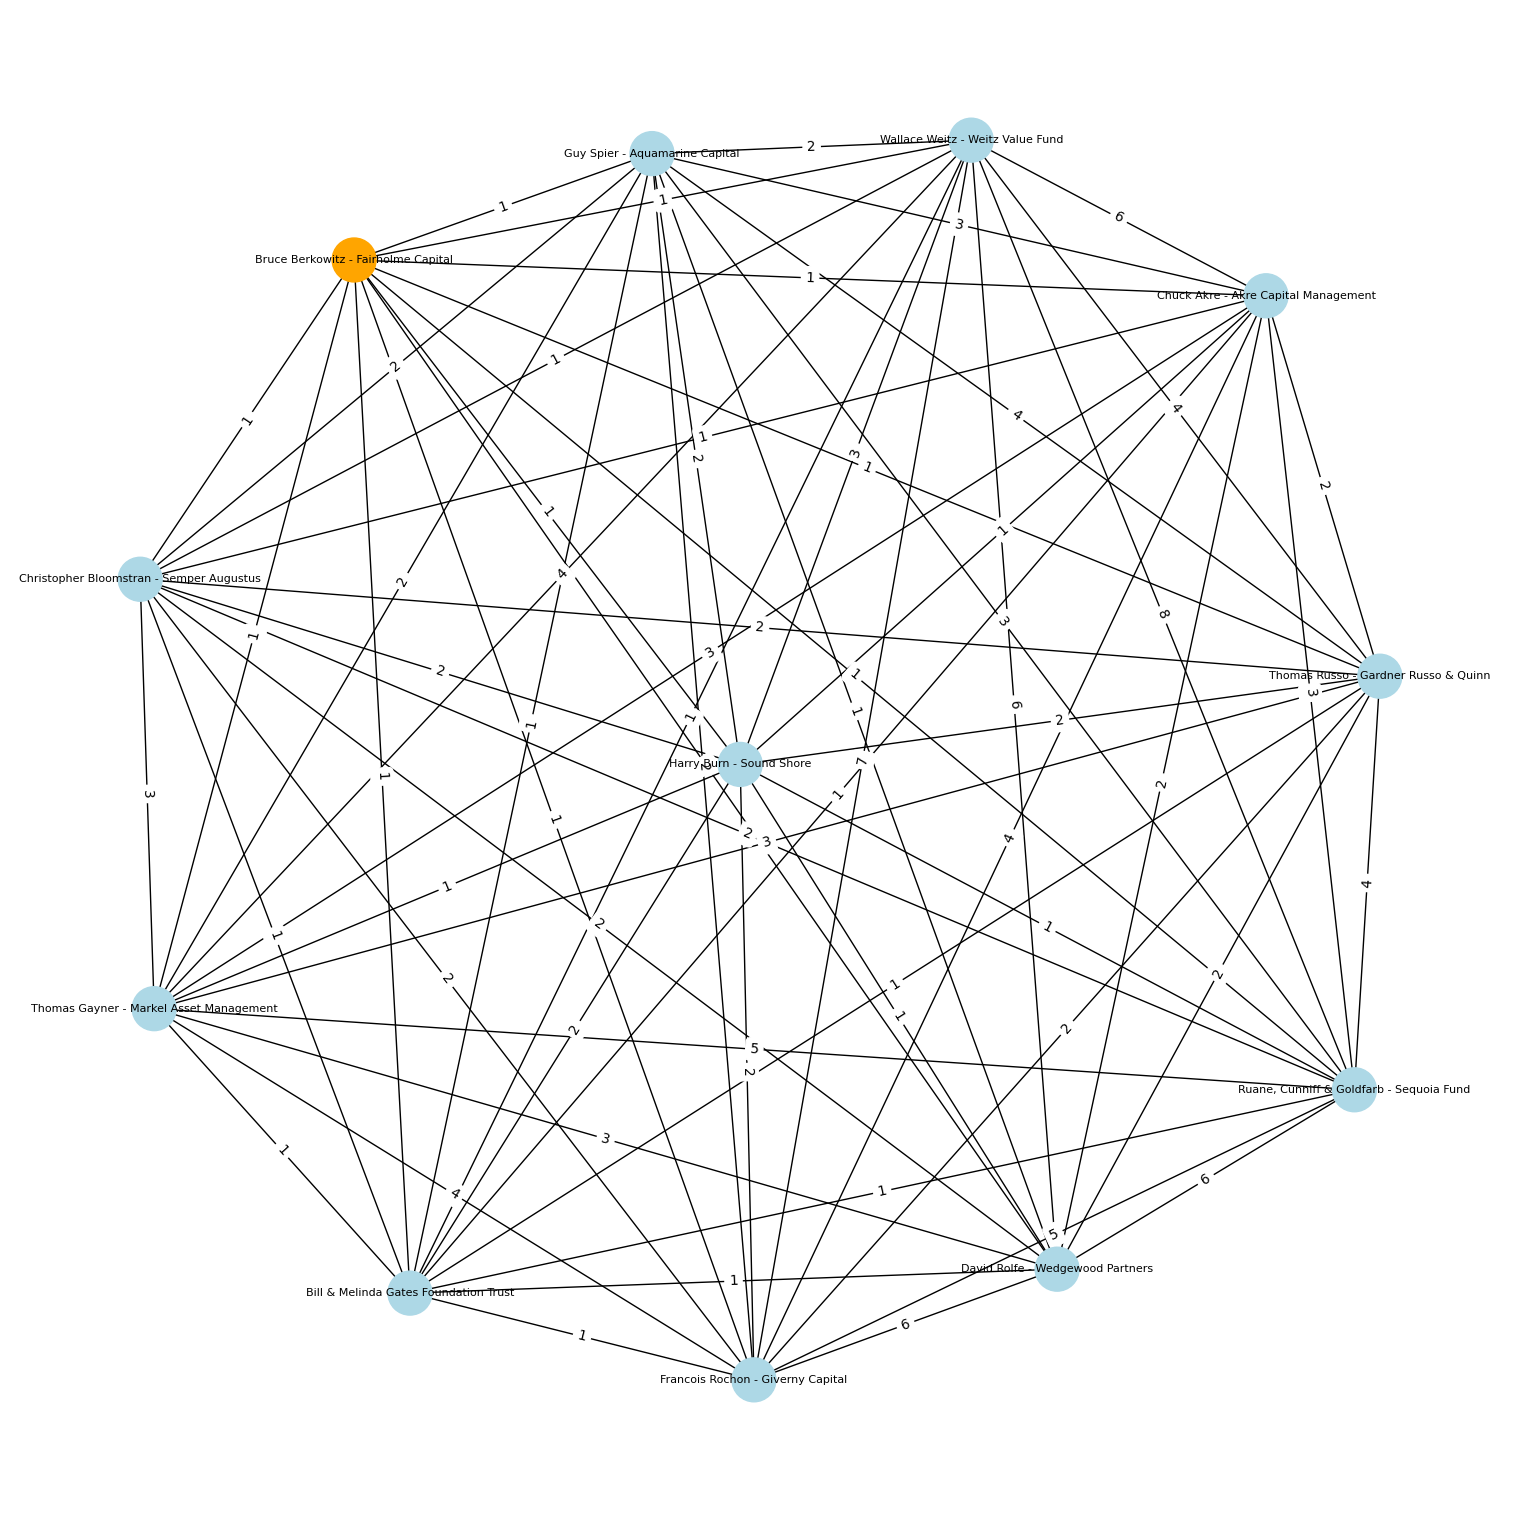

In [162]:
# CODE HERE
Ego_G_2019_Q1 = build_ego_network_for_node(G_2019_Q1, 'Bruce Berkowitz - Fairholme Capital')

draw_graphviz(Ego_G_2019_Q1, 'Ego_G_2019_Q1', 'lightblue', 'fdp')

#### Part 2: Basic Network Analysis

**Task 2.1 (15 marks)** <br>
Now that you know how to build the network for a single quarter and get its largest connected component, repeat the procedure for all the other quarters. For both the whole network and the ego-network, produce a table with the summary statistics (i.e. mean, max, min, and standard deviation) of the following network quantities:

- Number of nodes
- Number of links
- Density
- Average clustering coefficient
- Average degrees
- Average strength
- Assortativity

If you need to make any assumption or decision regarding the metric to use to compute any of these quantities, clearly motivate it.

In [166]:
add_strength_to_nodes(G_2019_Q1)
add_clustering_to_nodes(G_2019_Q1)

ns_G_2019_Q1 = get_network_summary_for_graph(G_2019_Q1)

  #nodes    #edges         d       <C>      <k>     <s>    k-Assort    s-Assort    C-Assort
--------  --------  --------  --------  -------  ------  ----------  ----------  ----------
      71      1070  0.430584  0.645887  30.1408  57.662   0.0582472   0.0393866    0.157228


In [167]:
add_strength_to_nodes(Ego_G_2019_Q1)
add_clustering_to_nodes(Ego_G_2019_Q1)

ns_Ego_G_2019_Q1 = get_network_summary_for_graph(Ego_G_2019_Q1)

  #nodes    #edges    d    <C>    <k>      <s>    k-Assort    s-Assort    C-Assort
--------  --------  ---  -----  -----  -------  ----------  ----------  ----------
      12        66    1      1     11  26.3333         nan  -0.0909091         nan


In [171]:
#CODE HERE
summaryWhole = {}
summaryEgo = {}

summaryWhole["G_2019_Q1"] = ns_G_2019_Q1
summaryEgo["G_2019_Q1"] = ns_Ego_G_2019_Q1

In [172]:
df_2019_Q2 = pd.read_excel('./Assignment_Data/2019_Q2.xlsx', header=None)

G_2019_Q2 = nx.Graph()
populate_graph(G_2019_Q2, df_2019_Q2)

Giant_G_2019_Q2 = extra_giant_component_from_graph(G_2019_Q2)

Ego_G_2019_Q2 = build_ego_network_for_node(G_2019_Q2, 'Bruce Berkowitz - Fairholme Capital')

add_strength_to_nodes(G_2019_Q2)
add_clustering_to_nodes(G_2019_Q2)
add_strength_to_nodes(Ego_G_2019_Q2)
add_clustering_to_nodes(Ego_G_2019_Q2)

ns_G_2019_Q2 = get_network_summary_for_graph(G_2019_Q2)
ns_Ego_G_2019_Q2 = get_network_summary_for_graph(Ego_G_2019_Q2)
summaryWhole["G_2019_Q2"] = ns_G_2019_Q2
summaryEgo["G_2019_Q2"] = ns_Ego_G_2019_Q2

/Users/teofebano/anaconda3/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [173]:
df_2019_Q3 = pd.read_excel('./Assignment_Data/2019_Q3.xlsx', header=None)

G_2019_Q3 = nx.Graph()
populate_graph(G_2019_Q3, df_2019_Q3)

Giant_G_2019_Q3 = extra_giant_component_from_graph(G_2019_Q3)

Ego_G_2019_Q3 = build_ego_network_for_node(G_2019_Q3, 'Bruce Berkowitz - Fairholme Capital')

add_strength_to_nodes(G_2019_Q3)
add_clustering_to_nodes(G_2019_Q3)
add_strength_to_nodes(Ego_G_2019_Q3)
add_clustering_to_nodes(Ego_G_2019_Q3)

ns_G_2019_Q3 = get_network_summary_for_graph(G_2019_Q3)
ns_Ego_G_2019_Q3 = get_network_summary_for_graph(Ego_G_2019_Q3)
summaryWhole["G_2019_Q3"] = ns_G_2019_Q3
summaryEgo["G_2019_Q3"] = ns_Ego_G_2019_Q3

In [174]:
df_2019_Q4 = pd.read_excel('./Assignment_Data/2019_Q4.xlsx', header=None)

G_2019_Q4 = nx.Graph()
populate_graph(G_2019_Q4, df_2019_Q4)

Giant_G_2019_Q4 = extra_giant_component_from_graph(G_2019_Q4)

Ego_G_2019_Q4 = build_ego_network_for_node(G_2019_Q4, 'Bruce Berkowitz - Fairholme Capital')

add_strength_to_nodes(G_2019_Q4)
add_clustering_to_nodes(G_2019_Q4)
add_strength_to_nodes(Ego_G_2019_Q4)
add_clustering_to_nodes(Ego_G_2019_Q4)

ns_G_2019_Q4 = get_network_summary_for_graph(G_2019_Q4)
ns_Ego_G_2019_Q4 = get_network_summary_for_graph(Ego_G_2019_Q4)
summaryWhole["G_2019_Q4"] = ns_G_2019_Q4
summaryEgo["G_2019_Q4"] = ns_Ego_G_2019_Q4

/Users/teofebano/anaconda3/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [ ]:
df_2020_Q1 = pd.read_excel('./Assignment_Data/2020_Q1.xlsx', header=None)

G_2020_Q1 = nx.Graph()
populate_graph(G_2020_Q1, df_2020_Q1)

Ego_G_2020_Q1 = build_ego_network_for_node(G_2020_Q1, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2020_Q1)
print_network_summary_for_graph(Ego_G_2020_Q1)

In [ ]:
df_2020_Q2 = pd.read_excel('./Assignment_Data/2020_Q2.xlsx', header=None)

G_2020_Q2 = nx.Graph()
populate_graph(G_2020_Q2, df_2020_Q2)

Giant_G_2020_Q2 = extra_giant_component_from_graph(G_2020_Q2)

Ego_G_2020_Q2 = build_ego_network_for_node(G_2020_Q2, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2020_Q2)
print_network_summary_for_graph(Ego_G_2020_Q2)

In [ ]:
df_2020_Q3 = pd.read_excel('./Assignment_Data/2020_Q3.xlsx', header=None)

G_2020_Q3 = nx.Graph()
populate_graph(G_2020_Q3, df_2020_Q3)

Giant_G_2020_Q3 = extra_giant_component_from_graph(G_2020_Q3)

Ego_G_2020_Q3 = build_ego_network_for_node(G_2020_Q3, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2020_Q3)
print_network_summary_for_graph(Ego_G_2020_Q3)

In [ ]:
df_2020_Q4 = pd.read_excel('./Assignment_Data/2020_Q4.xlsx', header=None)

G_2020_Q4 = nx.Graph()
populate_graph(G_2020_Q4, df_2020_Q4)

Giant_G_2020_Q4 = extra_giant_component_from_graph(G_2020_Q4)

Ego_G_2020_Q4 = build_ego_network_for_node(G_2020_Q4, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2020_Q4)
print_network_summary_for_graph(Ego_G_2020_Q4)

In [ ]:
df_2021_Q1 = pd.read_excel('./Assignment_Data/2021_Q1.xlsx', header=None)

G_2021_Q1 = nx.Graph()
populate_graph(G_2021_Q1, df_2021_Q1)

Giant_G_2021_Q1 = extra_giant_component_from_graph(G_2021_Q1)

Ego_G_2021_Q1 = build_ego_network_for_node(G_2021_Q1, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2021_Q1)
print_network_summary_for_graph(Ego_G_2021_Q1)

In [ ]:
df_2021_Q2 = pd.read_excel('./Assignment_Data/2021_Q2.xlsx', header=None)

G_2021_Q2 = nx.Graph()
populate_graph(G_2021_Q2, df_2021_Q2)

Giant_G_2021_Q2 = extra_giant_component_from_graph(G_2021_Q2)

Ego_G_2021_Q2 = build_ego_network_for_node(G_2021_Q2, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2021_Q2)
print_network_summary_for_graph(Ego_G_2021_Q2)

In [ ]:
df_2021_Q3 = pd.read_excel('./Assignment_Data/2021_Q3.xlsx', header=None)

G_2021_Q3 = nx.Graph()
populate_graph(G_2021_Q3, df_2021_Q3)

Giant_G_2021_Q3 = extra_giant_component_from_graph(G_2021_Q3)

Ego_G_2021_Q3 = build_ego_network_for_node(G_2021_Q3, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2021_Q3)
print_network_summary_for_graph(Ego_G_2021_Q3)

In [ ]:
df_2021_Q4 = pd.read_excel('./Assignment_Data/2021_Q4.xlsx', header=None)

G_2021_Q4 = nx.Graph()
populate_graph(G_2021_Q4, df_2021_Q4)

Giant_G_2021_Q4 = extra_giant_component_from_graph(G_2021_Q4)

Ego_G_2021_Q4 = build_ego_network_for_node(G_2021_Q4, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2021_Q4)
print_network_summary_for_graph(Ego_G_2021_Q4)

In [ ]:
df_2022_Q1 = pd.read_excel('./Assignment_Data/2022_Q1.xlsx', header=None)

G_2022_Q1 = nx.Graph()
populate_graph(G_2022_Q1, df_2022_Q1)

Giant_G_2022_Q1 = extra_giant_component_from_graph(G_2022_Q1)

Ego_G_2022_Q1 = build_ego_network_for_node(G_2022_Q1, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2022_Q1)
print_network_summary_for_graph(Ego_G_2022_Q1)

In [ ]:
df_2022_Q2 = pd.read_excel('./Assignment_Data/2022_Q2.xlsx', header=None)

G_2022_Q2 = nx.Graph()
populate_graph(G_2022_Q2, df_2022_Q2)

Giant_G_2022_Q2 = extra_giant_component_from_graph(G_2022_Q2)

Ego_G_2022_Q2 = build_ego_network_for_node(G_2022_Q2, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2022_Q2)
print_network_summary_for_graph(Ego_G_2022_Q2)

In [ ]:
df_2022_Q3 = pd.read_excel('./Assignment_Data/2022_Q3.xlsx', header=None)

G_2022_Q3 = nx.Graph()
populate_graph(G_2022_Q3, df_2022_Q3)

Giant_G_2022_Q3 = extra_giant_component_from_graph(G_2022_Q3)

Ego_G_2022_Q3 = build_ego_network_for_node(G_2022_Q3, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2022_Q3)
print_network_summary_for_graph(Ego_G_2022_Q3)

In [ ]:
df_2022_Q4 = pd.read_excel('./Assignment_Data/2022_Q4.xlsx', header=None)

G_2022_Q4 = nx.Graph()
populate_graph(G_2022_Q4, df_2022_Q4)

Giant_G_2022_Q4 = extra_giant_component_from_graph(G_2022_Q4)

Ego_G_2022_Q4 = build_ego_network_for_node(G_2022_Q4, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2022_Q4)
print_network_summary_for_graph(Ego_G_2022_Q4)

In [ ]:
df_2023_Q1 = pd.read_excel('./Assignment_Data/2023_Q1.xlsx', header=None)

G_2023_Q1 = nx.Graph()
populate_graph(G_2023_Q1, df_2023_Q1)

Giant_G_2023_Q1 = extra_giant_component_from_graph(G_2023_Q1)

Ego_G_2023_Q1 = build_ego_network_for_node(G_2023_Q1, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2023_Q1)
print_network_summary_for_graph(Ego_G_2023_Q1)

In [ ]:
df_2023_Q2 = pd.read_excel('./Assignment_Data/2023_Q2.xlsx', header=None)

G_2023_Q2 = nx.Graph()
populate_graph(G_2023_Q2, df_2023_Q2)

Giant_G_2023_Q2 = extra_giant_component_from_graph(G_2023_Q2)

Ego_G_2023_Q2 = build_ego_network_for_node(G_2023_Q2, 'Bruce Berkowitz - Fairholme Capital')

print_network_summary_for_graph(G_2023_Q2)
print_network_summary_for_graph(Ego_G_2023_Q2)

**Task 2.2 (10 marks)** </br>
Discuss why ego networks are useful for exploring the importance of singular nodes. Then, comment on the statistics you computed above and what information they give you about the investment patterns of Bruce Berkowitz - Fairholme Capital. Briefly discuss how the ego network statistics differ from the statistics obtained for the whole network, explaining whether the differences or similarities are expected or not. Motivate your answers. 

**Discuss:**

#### Part 3: Comparing Degree Distributions

**Task 3.1 (8 marks)** </br>
Choose a single temporal slice (i.e. quarter) and plot and analyse the total degree and strength distributions of both the whole network and the ego-network. Comment on the similarities/differences between these networks. 

In [21]:
#CODE HERE

**Task 3.2 (7 marks)** </br> 
Based on degree distributions and the results you obtained, what type of network would you say the whole network and ego-network are (e.g scale free, random, etc)? Could have they been generated by any of the models discussed in class? Motivate your answer.

In [22]:
#CODE HERE

**Discuss:**

#### Part 4: Changes of the network statistics during the pandemic

**Task 4.1 (15 marks)** </br> Plot the temporal evolution of the quantities you computed in Part 2 for the ego network and the whole network compare the difference between the networks. For each quantity, discuss if it can be used for analysing the investment patterns of Bruce Berkowitz - Fairholme Capital over time. Based on your discussion, choose the quantities that you find important. What information you can draw about the change of those network statistics during the pandemic?

In [24]:
#CODE HERE

**Tasks 4.2 (10 marks)** </br> Choose a suitable centrality measure that would give us imporatnt information about the nodes in the whole network, and clearly motivate your choice. Use this measure to find the 3 most central nodes for each quarter. Compare the centrality of Bruce Berkowitz - Fairholme Capital overtime with that of the most central nodes. What can you conclude from this?

In [17]:
#CODE HERE

**Discuss:**

#### Part 5: Clustering and Modularity

**Task 5.1 (15 marks)** </br> Find the communities in each quarter in the whole network. To do so, use an algorithm of your choice, and justify your decision. Analyse how the communities evolve overtime, focussing on the membership of Bruce Berkowitz - Fairholme Capital. Does this node fall in the same community with the same superinvestors across different quarters? What conclusions can you draw from this?

In [18]:
#CODE HERE

**Discuss:**

#### Part 6: Report your findings

**Task 6.1 (10 marks)** </br> As any good DBBA Capital data analyst, at the end of your analysis you need to present your fidnings. Please write a brief (~250 words) report discussing how the portfolio of Fairholme Capital has changed compared with the rest of the funds in the dataset.

**REPORT**
